In [1]:
#importing needed libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

#importing needed models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#importing model evaluators 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import our 2 datasets and merge them into 1

os.chdir('C:\\Users\\solov\\Desktop\\sample_project\\data')

df1 = pd.read_csv('ATL_ready_ML.csv') #Atlanta dataset
df2 = pd.read_csv('PHX_ready_ML.csv') #Phoenix dataset

In [3]:
len(df1) #number of samples in Atlanta

12766

In [4]:
len(df2) #number of samples in Phoenix

57270

In [5]:
len(df1) + len(df2) #the sum of samples

70036

In [6]:
#here we concatenate the 2 dataframes, 
#meaning stack them one on top of the other
#and the resulting sum of samples should be as in previous step
df = pd.concat([df1,df2],ignore_index=True)
len(df)

70036

In [7]:
df['Target'] = df['DepDel15']
df = df.drop('DepDel15',axis=1)

In [8]:
#here we see that our column DepDel15 has far more
#on-time flights rather than delayed flights

#this is called unbalanced dataset
df.Target.value_counts(normalize=True)

Target
0    0.8324
1    0.1676
Name: proportion, dtype: float64

## So you see that there's a lot more ON TIME flights than DELAYED flights

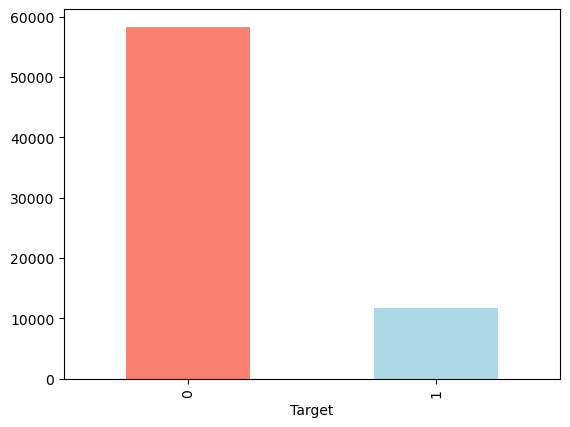

In [9]:
df.Target.value_counts().plot(kind='bar',color=['salmon','lightblue']);

In [10]:
#just checking that we've used data from all 64 encoded airports

arr = df.dest_airport_label.unique()
sorted_arr = np.sort(arr)
sorted_arr

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61, 100, 101],
      dtype=int64)

##  DELETING unwanted columns

In [11]:
df.columns

Index(['flight_number', 'scheduled_elapsed_time_(minutes)',
       'actual_elapsed_time_(minutes)', 'departure_delay_(minutes)',
       'taxi-out_time_(minutes)', 'dest_airport_label', 'month', 'day',
       'act_dep_time_hr', 'act_dep_time_min', 'sch_dep_time_hr',
       'sch_dep_time_min', 'wo_time_hr', 'wo_time_min', 'Target'],
      dtype='object')

In [12]:
df = df.drop(['wo_time_hr', 'wo_time_min', 
             'departure_delay_(minutes)','act_dep_time_hr', 'act_dep_time_min', 
              'actual_elapsed_time_(minutes)', 'taxi-out_time_(minutes)'], axis=1)

In [13]:
df.columns

Index(['flight_number', 'scheduled_elapsed_time_(minutes)',
       'dest_airport_label', 'month', 'day', 'sch_dep_time_hr',
       'sch_dep_time_min', 'Target'],
      dtype='object')

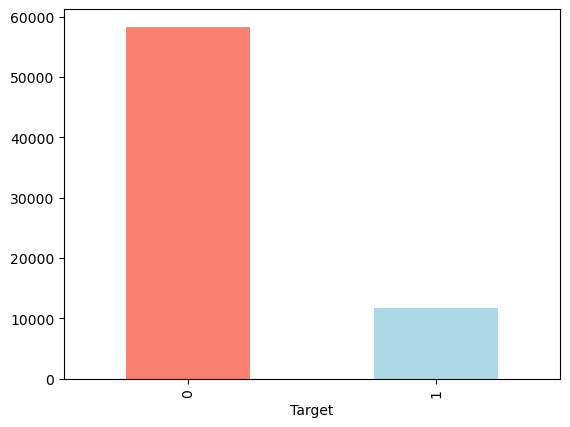

In [14]:
df.Target.value_counts().plot(kind='bar',color=['salmon','lightblue']);

In [15]:
#let's find the correlation between our independent variables

corr_matrix = df.corr()
corr_matrix

,flight_number,scheduled_elapsed_time_(minutes),dest_airport_label,month,day,sch_dep_time_hr,sch_dep_time_min,Target
flight_number,1.000000,-0.045606,-0.060748,0.014730,0.007307,0.004764,-0.057796,-0.002362
scheduled_elapsed_time_(minutes),-0.045606,1.000000,-0.175248,-0.002166,0.000688,-0.036578,-0.015485,0.019767
dest_airport_label,-0.060748,-0.175248,1.000000,-0.004445,-0.002233,0.074366,-0.013931,-0.000132
month,0.014730,-0.002166,-0.004445,1.000000,0.017713,-0.002151,-0.007696,0.003563
day,0.007307,0.000688,-0.002233,0.017713,1.000000,-0.005673,0.003120,0.002186
sch_dep_time_hr,0.004764,-0.036578,0.074366,-0.002151,-0.005673,1.000000,-0.034313,0.084906
sch_dep_time_min,-0.057796,-0.015485,-0.013931,-0.007696,0.003120,-0.034313,1.000000,0.004813
Target,-0.002362,0.019767,-0.000132,0.003563,0.002186,0.084906,0.004813,1.000000


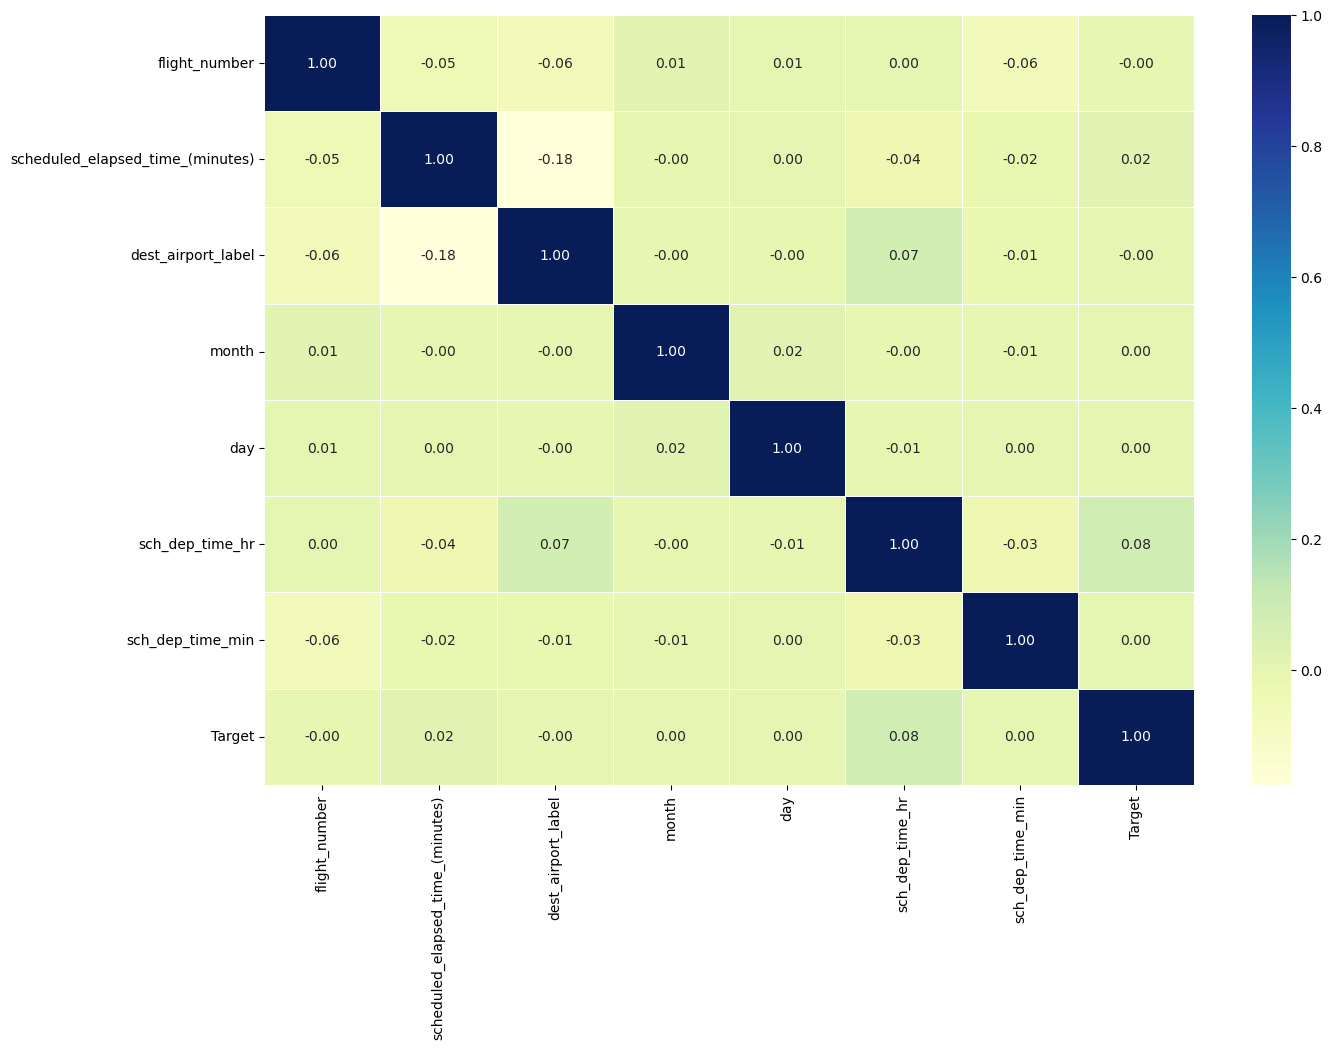

In [16]:
#And to make it visual:
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True,linewidths=0.5,
           fmt=".2f", cmap="YlGnBu");

## Now let's start with modelling

In [17]:
#let's split our data 

X = df.drop('Target', axis=1)

y = df.Target.values

#Let's see our new variables

In [18]:
print('Independent variables: ')
X.head()

Independent variables: 


,flight_number,scheduled_elapsed_time_(minutes),dest_airport_label,month,day,sch_dep_time_hr,sch_dep_time_min
0,242,156,14,1,1,18,23
1,401,128,45,1,1,15,22
2,426,81,8,1,1,10,56
3,440,262,100,1,1,17,40
4,448,146,14,1,1,21,46


In [19]:
print('Target: ')
y

Target: 


array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
#Let's now split the data into train and test split

np.random.seed(40)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training data

In [21]:
X_train.head()

,flight_number,scheduled_elapsed_time_(minutes),dest_airport_label,month,day,sch_dep_time_hr,sch_dep_time_min
41570,1437,164,44,6,30,9,55
17109,2651,283,26,1,28,0,20
11057,2778,156,14,11,11,9,57
35113,2856,157,24,5,20,15,20
3288,2778,154,14,4,13,10,6


In [22]:
y_train, len(y_train) #so we're training our model on 56028 samples

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 56028)

In [23]:
count_zeros = np.sum(y_train == 0)
count_ones = np.sum(y_train == 1)

In [24]:
count_ones

9371

In [25]:
count_zeros

46657

## Testing data

In [26]:
X_test.head()

,flight_number,scheduled_elapsed_time_(minutes),dest_airport_label,month,day,sch_dep_time_hr,sch_dep_time_min
48346,2100,240,16,12,8,9,8
52623,2490,77,58,10,9,17,0
47549,1765,151,14,7,8,7,25
40691,567,245,8,6,25,6,21
45865,470,105,55,7,28,13,49


In [27]:
y_test, len(y_test) #so we'll use 14008 samples to test our model on

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 14008)

In [28]:
count_zeros = np.sum(y_test == 0)
count_ones = np.sum(y_test == 1)

In [29]:
count_ones

2367

In [30]:
count_zeros

11641

## Creating models

All of the algorithms in the Scikit-Learn library use the same functions, 
for training a model, `model.fit(X_train, y_train)` and for scoring a 
model `model.score(X_test, y_test)`. `score()` 
returns the ratio of correct predictions (1.0 = 100% correct).

## KNN classifier

In [31]:
np.random.seed(42)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

knn_score = knn.score(X_test,y_test)
print(knn_score)
print(f"Flight is predicted to be accurately delayed or on time with accuracy: {knn_score * 100:.2f}%")

0.8060394060536836
Flight is predicted to be accurately delayed or on time with accuracy: 80.60%


In [32]:
y_preds = knn.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm

array([[11068,   573],
       [ 2144,   223]], dtype=int64)

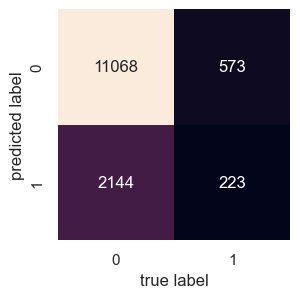

In [33]:
sns.set(font_scale=1)
def plot_conf_mat(y_test,y_preds):
    """
    plots a confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(cm,
                    annot = True, fmt ='d', cbar = False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

### Let's get down to tuning

Let's try and adjust the number of neigbours in the KNN algorithm. The default value is `n_neigbours = 5`

In [34]:
#create a list of train scores

train_scores = []

#create a list of test scores
test_scores = []

#create a list of different values for n_neighbors
neighbors = range(1,21) #1 to 20

#setup algorithm
knn = KNeighborsClassifier()

#loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i)
    
    #fit the algorithm
    knn.fit(X_train, y_train)
    
    #update the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    #update the test scores
    test_scores.append(knn.score(X_test,y_test))

In [35]:
train_scores

[1.0,
 0.8694224316413222,
 0.8710644677661169,
 0.8487363461126579,
 0.8496466052687942,
 0.8414185764260727,
 0.8420789605197402,
 0.8384200756764475,
 0.8389733704576283,
 0.8372420932390947,
 0.8375455129578068,
 0.8358677803955166,
 0.8361355036767331,
 0.8350646105518669,
 0.835136003426858,
 0.8344756193331906,
 0.8347790390519026,
 0.8345291639894339,
 0.8345291639894339,
 0.8341186549582351]

In [36]:
test_scores

[0.7395059965733867,
 0.8158195316961736,
 0.7928326670474015,
 0.8196030839520274,
 0.8060394060536836,
 0.8217447173043975,
 0.815676756139349,
 0.8259565962307253,
 0.8216019417475728,
 0.8278840662478584,
 0.8255996573386636,
 0.8285979440319817,
 0.8268846373500857,
 0.8290262707024557,
 0.8274557395773844,
 0.828669331810394,
 0.8283837806967447,
 0.8292404340376928,
 0.8290262707024557,
 0.8304540262707024]

Maximum KNN score on the test data: 83.05%


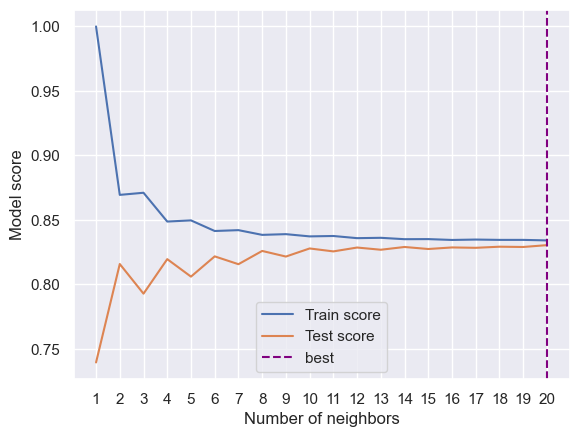

In [37]:
plt.plot(neighbors, train_scores, label='Train score')
plt.plot(neighbors, test_scores, label='Test score')
plt.axvline(x=20, color='purple', linestyle='--', label='best')
plt.xticks(np.arange(1,21,1))
plt.xlabel('Number of neighbors')
plt.ylabel('Model score')
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

### Tuned model performs a little bit better

In [38]:
np.random.seed(42)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)

knn_score = knn.score(X_test,y_test)
print(knn_score)
print(f"Flight is predicted to be accurately delayed or on time with accuracy: {knn_score * 100:.2f}%")

0.8304540262707024
Flight is predicted to be accurately delayed or on time with accuracy: 83.05%


In [39]:
Y_preds = knn.predict(X_test)
CM = confusion_matrix(y_test, Y_preds)
CM

array([[11589,    52],
       [ 2323,    44]], dtype=int64)

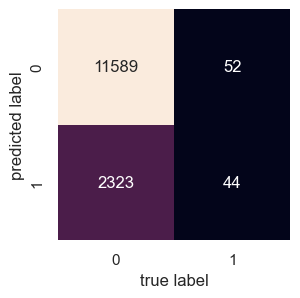

In [40]:
sns.set(font_scale=1)
def plot_conf_mat(y_test,y_preds):
    """
    plots a confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(CM,
                    annot = True, fmt ='d', cbar = False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, Y_preds)

## SVC classifier

In [41]:
svc = svm.SVC()

svc.fit(X_train,y_train)

svc_score = svc.score(X_test,y_test)
print(svc_score)
print(f"Flight is predicted to be accurately delayed or on time with accuracy: {svc_score * 100:.2f}%")

0.8310251284980011
Flight is predicted to be accurately delayed or on time with accuracy: 83.10%


In [42]:
predictions = svc.predict(X_test)
cmx = confusion_matrix(y_test, predictions)
cmx

array([[11641,     0],
       [ 2367,     0]], dtype=int64)

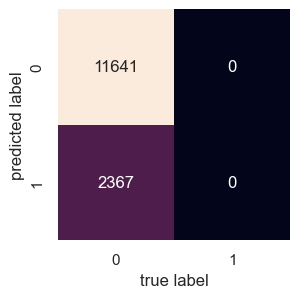

In [43]:
sns.set(font_scale=1)
def plot_conf_mat(y_test,y_preds):
    """
    plots a confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(cmx,
                    annot = True, fmt ='d', cbar = False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds=predictions)

## Random Forest Classifier

In [44]:
np.random.seed(17)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
clf_score = clf.score(X_test,y_test)

print(clf_score)
print(f"Flight is predicted to be accurately delayed or on time with accuracy: {clf_score * 100:.2f}%")

0.7771987435751
Flight is predicted to be accurately delayed or on time with accuracy: 77.72%


In [45]:
Predictions = clf.predict(X_test)
Cmx = confusion_matrix(y_test, Predictions)
Cmx

array([[10528,  1113],
       [ 2008,   359]], dtype=int64)

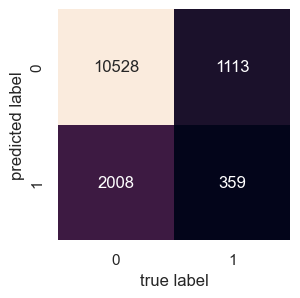

In [46]:
sns.set(font_scale=1)
def plot_conf_mat(y_test,y_preds):
    """
    plots a confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(Cmx,
                    annot = True, fmt ='d', cbar = False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds=Predictions)

## ROC curves

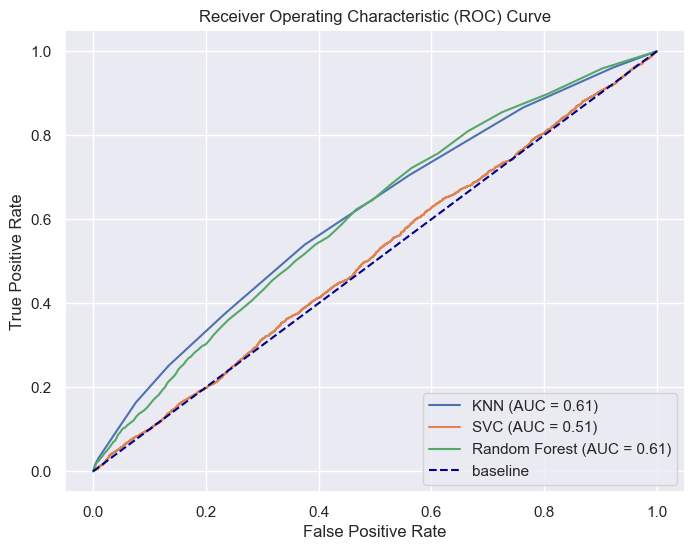

In [47]:
#get the probabilities for positive class for knn and svc and random forest
y_probs_knn = knn.predict_proba(X_test)[:, 1]
y_probs_svc = svc.decision_function(X_test)
y_probs_clf = clf.predict_proba(X_test)[:, 1]

#compute roc curve and roc area for knn
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_probs_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Compute ROC curve and ROC area for SVC
fpr_svc, tpr_svc, thresholds = roc_curve(y_test, y_probs_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Compute ROC curve and ROC area for Random forest
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, y_probs_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)

fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=roc_auc_knn, estimator_name = "KNN").plot(ax=ax)
RocCurveDisplay(fpr=fpr_svc, tpr=tpr_svc, roc_auc=roc_auc_svc, estimator_name = "SVC").plot(ax=ax)
RocCurveDisplay(fpr=fpr_clf, tpr=tpr_clf, roc_auc=roc_auc_clf, estimator_name = "Random Forest").plot(ax=ax)
plt.plot([0,1],[0,1], color='darkblue', linestyle='--',label='baseline')

# Add labels and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

## Classification report

In [48]:
#KNN classifier 
CR_knn = classification_report(y_test, Y_preds)

#SVC classifier
CR_svc = classification_report(y_test, predictions)

#Random Forest classifier
CR_clf = classification_report(y_test, Predictions)

### Classification report for KNN

#### Legend: 
    ***Precision*** - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.
    ***Recall*** - Indicates the proportion of actual positives which were correctly classified. A model which produces no false negatives has a recall of 1.0.
    ***F1 score*** - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.
    ***Support*** - The number of samples each metric was calculated on.
    ***Accuracy*** - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0.
    ***Macro avg*** - Short for macro average, the average precision, recall and F1 score between classes. Macro avg doesn’t class imbalance into effort, so if you do have class imbalances, pay attention to this metric.
    ***Weighted avg*** - Short for weighted average, the weighted average precision, recall and F1 score between classes. Weighted means each metric is calculated with respect to how many samples there are in each class. This metric will favour the majority class (e.g. will give a high value when one class out performs another due to having more samples).

In [50]:
print(CR_knn)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     11641
           1       0.46      0.02      0.04      2367

    accuracy                           0.83     14008
   macro avg       0.65      0.51      0.47     14008
weighted avg       0.77      0.83      0.76     14008



In [51]:
print(CR_svc)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     11641
           1       0.00      0.00      0.00      2367

    accuracy                           0.83     14008
   macro avg       0.42      0.50      0.45     14008
weighted avg       0.69      0.83      0.75     14008



In [52]:
print(CR_clf)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     11641
           1       0.24      0.15      0.19      2367

    accuracy                           0.78     14008
   macro avg       0.54      0.53      0.53     14008
weighted avg       0.74      0.78      0.76     14008

